In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2

from tqdm import tqdm

import torch
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms

In [2]:
def add_noise(img, noise_type="gaussian", mean=0, var=1):
    row, col = 64, 64
    img = img.astype(np.float32)
    sigma = var ** .5

    if noise_type == "gaussian":
        noise = np.random.normal(mean, sigma, img.shape)
        noise = noise.reshape(row, col)
        img = img + noise
        return img

    if noise_type == "speckle":
        noise = np.random.gamma(mean, scale=sigma, size=img.shape)
        img = img * noise
        return img

def snr(img1, img2):
    sz = img1.shape
    acc_num = 0
    acc_den = 0

    for i in range(0, sz[0]):
        for j in range(0, sz[1]):
            acc_num += img1[i][j] ** 2
            acc_den += (img1[i][j] - img2[i][j]) ** 2

    return acc_num / acc_den

def psnr(img1, img2):
    sz = img1.shape
    acc_mse = 0

    for i in range(0, sz[0]):
        for j in range(0, sz[1]):
            acc_mse += (img1[i][j] - img2[i][j]) ** 2

    acc_mse /= (sz[0] * sz[1])

    return 10 * np.log(255 ** 2 / acc_mse)

def normalisation(X):
    minX = np.min(X)
    maxX = np.max(X)

    return (X - minX)/(maxX - minX)

In [3]:
data = []
imgs_path = "data"

kernel = np.ones((2,2),np.uint8)

for filename in os.listdir(imgs_path):
            f = os.path.join(imgs_path, filename)
            data.append(cv2.threshold(cv2.dilate(cv2.imread(f, 0), kernel), 20, 255, cv2.THRESH_BINARY)[1])

random.shuffle(data)

xtrain = data[:14000]
xtest = data[14000:]

noises = ["gaussian", "speckle"]
mean = 0
var = 1000.
lb = 1.1
a = lb
scale = 1 / (lb - 1)
noise_ct = 0
noise_id = 0
traindata = np.zeros((14000, 64, 64))

for idx in tqdm(range(len(xtrain))):
    traindata[idx] = add_noise(xtrain[idx], noise_type=noises[noise_id], mean=mean, var=var)


print("\n{} noise addition completed to images".format(noises[noise_id]))

testdata = np.zeros((956, 64, 64))

for idx in tqdm(range(len(xtest))):
    x = add_noise(xtest[idx], noise_type=noises[noise_id], mean=mean, var=var)
    testdata[idx] = x

print("\n{} noise addition completed to images".format(noises[noise_id]))

100%|██████████| 14000/14000 [00:01<00:00, 12509.48it/s]



gaussian noise addition completed to images


100%|██████████| 956/956 [00:00<00:00, 12987.65it/s]


gaussian noise addition completed to images


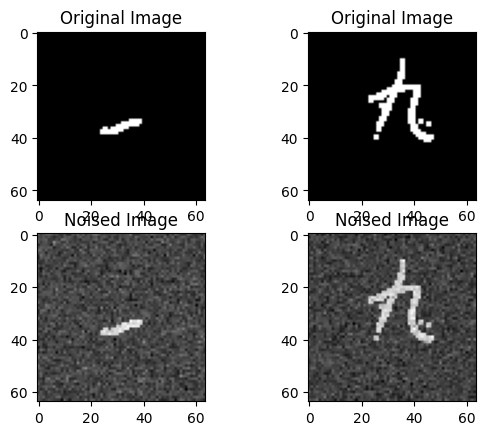

SNR:  0.7228113087202864
PSNR:  41.43011490334349


In [4]:
f, axes = plt.subplots(2, 2)

# showing images with gaussian noise
axes[0, 0].imshow(xtrain[0], cmap="gray")
axes[0, 0].set_title("Original Image")
axes[1, 0].imshow(traindata[0], cmap='gray')
axes[1, 0].set_title("Noised Image")

# showing images with speckle noise
axes[0, 1].imshow(xtrain[10000], cmap='gray')
axes[0, 1].set_title("Original Image")
axes[1, 1].imshow(traindata[10000], cmap="gray")
axes[1, 1].set_title("Noised Image")
plt.show()

snr_estim = snr(xtrain[0], traindata[0])
psnr_estim = psnr(xtrain[0], traindata[0])

print("SNR: ", snr_estim)
print("PSNR: ", psnr_estim)

In [37]:
class noisedDataset(Dataset):
    def __init__(self, datasetnoised, datasetclean, transform):
        self.noise = datasetnoised
        self.clean = datasetclean
        self.transform = transform

    def __len__(self):
        return len(self.noise)

    def __getitem__(self, idx):
        xNoise = self.noise[idx]
        xClean = self.clean[idx]

        if self.transform is not None:
            xNoise = self.transform(xNoise)
            xClean = self.transform(xClean)

        return xNoise, xClean

In [38]:
tsfms = transforms.Compose([transforms.ToTensor(), transforms.Resize((32, 32))])

trainset = noisedDataset(traindata, xtrain, tsfms)
testset = noisedDataset(testdata, xtest, tsfms)

batch_size = 32

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=1, shuffle=True)

In [55]:
from torch import nn

class denoising_model(nn.Module):
    def __init__(self):
        super(denoising_model, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(32*32, 512),
            nn.ReLU(True),
            nn.Linear(512, 384),
            nn.ReLU(True),
            nn.Linear(384, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True)

        )

        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 384),
            nn.ReLU(True),
            nn.Linear(384, 512),
            nn.ReLU(True),
            nn.Linear(512, 32*32),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [56]:
if torch.cuda.is_available() == True:
    device = "cuda:0"
else:
    device = "cpu"

print(device)

model = denoising_model().to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-5)

epochs = 100
l = len(trainloader)
losslist = list()
epochloss = 0
running_loss = 0

cuda:0


In [53]:
image_test = []
for dirty, clean in testloader:
    image_test = dirty

image_test = image_test.view(1, -1).type(torch.FloatTensor)

image_test = image_test.to(device)

In [57]:
%matplotlib qt

for epoch in range(epochs):

    print("Entering Epoch: ", epoch)
    for dirty, clean in tqdm((trainloader)):
        dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor)
        clean = clean.view(clean.size(0), -1).type(torch.FloatTensor)
        dirty, clean = dirty.to(device), clean.to(device)

        # -----------------Forward Pass----------------------
        output = model(dirty)
        loss = criterion(output, clean)
        # -----------------Backward Pass---------------------
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epochloss += loss.item()
    # -----------------Log-------------------------------
    losslist.append(running_loss / l)
    running_loss = 0
    print("======> epoch: {}/{}, Loss:{}".format(epoch, epochs, loss.item()))

    image_res = model(image_test)

    image_res = image_res.view(1, 32, 32)
    image_res = image_res.permute(1, 2, 0).squeeze(2)
    image_res = image_res.detach().cpu().numpy()

    plt.imshow(image_res)
    plt.pause(0.01)

%matplotlib inline

Entering Epoch:  0


100%|██████████| 438/438 [00:03<00:00, 127.56it/s]


======> epoch: 0/100, Loss:0.23948436975479126
Entering Epoch:  1


100%|██████████| 438/438 [00:02<00:00, 146.82it/s]


======> epoch: 1/100, Loss:0.2388852834701538
Entering Epoch:  2


100%|██████████| 438/438 [00:03<00:00, 139.04it/s]


======> epoch: 2/100, Loss:0.24149245023727417
Entering Epoch:  3


100%|██████████| 438/438 [00:03<00:00, 138.57it/s]


======> epoch: 3/100, Loss:0.23914369940757751
Entering Epoch:  4


100%|██████████| 438/438 [00:02<00:00, 148.60it/s]


======> epoch: 4/100, Loss:0.23822981119155884
Entering Epoch:  5


100%|██████████| 438/438 [00:03<00:00, 139.15it/s]


======> epoch: 5/100, Loss:0.23322227597236633
Entering Epoch:  6


100%|██████████| 438/438 [00:03<00:00, 141.72it/s]


======> epoch: 6/100, Loss:0.19347912073135376
Entering Epoch:  7


100%|██████████| 438/438 [00:03<00:00, 145.70it/s]


======> epoch: 7/100, Loss:0.03288070112466812
Entering Epoch:  8


100%|██████████| 438/438 [00:03<00:00, 145.66it/s]


======> epoch: 8/100, Loss:0.03347180038690567
Entering Epoch:  9


100%|██████████| 438/438 [00:02<00:00, 146.44it/s]


======> epoch: 9/100, Loss:0.031016238033771515
Entering Epoch:  10


100%|██████████| 438/438 [00:03<00:00, 140.82it/s]


======> epoch: 10/100, Loss:0.03190421313047409
Entering Epoch:  11


100%|██████████| 438/438 [00:03<00:00, 139.92it/s]


======> epoch: 11/100, Loss:0.028934914618730545
Entering Epoch:  12


100%|██████████| 438/438 [00:02<00:00, 146.21it/s]


======> epoch: 12/100, Loss:0.040741465985774994
Entering Epoch:  13


100%|██████████| 438/438 [00:03<00:00, 144.29it/s]


======> epoch: 13/100, Loss:0.02979087084531784
Entering Epoch:  14


100%|██████████| 438/438 [00:03<00:00, 137.37it/s]


======> epoch: 14/100, Loss:0.03704683855175972
Entering Epoch:  15


100%|██████████| 438/438 [00:02<00:00, 152.07it/s]


======> epoch: 15/100, Loss:0.03277699649333954
Entering Epoch:  16


100%|██████████| 438/438 [00:02<00:00, 153.09it/s]


======> epoch: 16/100, Loss:0.034486379474401474
Entering Epoch:  17


100%|██████████| 438/438 [00:02<00:00, 157.11it/s]


======> epoch: 17/100, Loss:0.03272760286927223
Entering Epoch:  18


100%|██████████| 438/438 [00:02<00:00, 154.67it/s]


======> epoch: 18/100, Loss:0.027786798775196075
Entering Epoch:  19


100%|██████████| 438/438 [00:02<00:00, 146.35it/s]


======> epoch: 19/100, Loss:0.029116949066519737
Entering Epoch:  20


100%|██████████| 438/438 [00:02<00:00, 150.61it/s]


======> epoch: 20/100, Loss:0.026020808145403862
Entering Epoch:  21


100%|██████████| 438/438 [00:02<00:00, 154.95it/s]


======> epoch: 21/100, Loss:0.04112046957015991
Entering Epoch:  22


100%|██████████| 438/438 [00:03<00:00, 144.00it/s]


======> epoch: 22/100, Loss:0.028649024665355682
Entering Epoch:  23


100%|██████████| 438/438 [00:03<00:00, 133.80it/s]


======> epoch: 23/100, Loss:0.03620271757245064
Entering Epoch:  24


100%|██████████| 438/438 [00:03<00:00, 139.96it/s]


======> epoch: 24/100, Loss:0.029850829392671585
Entering Epoch:  25


100%|██████████| 438/438 [00:02<00:00, 152.62it/s]


======> epoch: 25/100, Loss:0.026137487962841988
Entering Epoch:  26


100%|██████████| 438/438 [00:03<00:00, 144.52it/s]


======> epoch: 26/100, Loss:0.03211423009634018
Entering Epoch:  27


100%|██████████| 438/438 [00:03<00:00, 130.56it/s]


======> epoch: 27/100, Loss:0.03509235009551048
Entering Epoch:  28


100%|██████████| 438/438 [00:03<00:00, 134.67it/s]


======> epoch: 28/100, Loss:0.02470511570572853
Entering Epoch:  29


100%|██████████| 438/438 [00:02<00:00, 156.86it/s]


======> epoch: 29/100, Loss:0.034794919192790985
Entering Epoch:  30


100%|██████████| 438/438 [00:02<00:00, 152.81it/s]


======> epoch: 30/100, Loss:0.033481664955616
Entering Epoch:  31


100%|██████████| 438/438 [00:03<00:00, 140.51it/s]


======> epoch: 31/100, Loss:0.024305790662765503
Entering Epoch:  32


100%|██████████| 438/438 [00:03<00:00, 144.99it/s]


======> epoch: 32/100, Loss:0.025016386061906815
Entering Epoch:  33


100%|██████████| 438/438 [00:02<00:00, 157.26it/s]


======> epoch: 33/100, Loss:0.02977576293051243
Entering Epoch:  34


100%|██████████| 438/438 [00:02<00:00, 153.59it/s]


======> epoch: 34/100, Loss:0.030928954482078552
Entering Epoch:  35


100%|██████████| 438/438 [00:03<00:00, 140.25it/s]


======> epoch: 35/100, Loss:0.0267909187823534
Entering Epoch:  36


100%|██████████| 438/438 [00:03<00:00, 135.48it/s]


======> epoch: 36/100, Loss:0.02356286160647869
Entering Epoch:  37


100%|██████████| 438/438 [00:03<00:00, 140.49it/s]


======> epoch: 37/100, Loss:0.023570431396365166
Entering Epoch:  38


100%|██████████| 438/438 [00:03<00:00, 138.01it/s]


======> epoch: 38/100, Loss:0.024685967713594437
Entering Epoch:  39


100%|██████████| 438/438 [00:03<00:00, 136.43it/s]


======> epoch: 39/100, Loss:0.02971258945763111
Entering Epoch:  40


100%|██████████| 438/438 [00:03<00:00, 137.93it/s]


======> epoch: 40/100, Loss:0.030159149318933487
Entering Epoch:  41


100%|██████████| 438/438 [00:03<00:00, 138.17it/s]


======> epoch: 41/100, Loss:0.02834552340209484
Entering Epoch:  42


100%|██████████| 438/438 [00:02<00:00, 146.04it/s]


======> epoch: 42/100, Loss:0.02501649782061577
Entering Epoch:  43


100%|██████████| 438/438 [00:02<00:00, 151.85it/s]


======> epoch: 43/100, Loss:0.0316038616001606
Entering Epoch:  44


100%|██████████| 438/438 [00:02<00:00, 151.46it/s]


======> epoch: 44/100, Loss:0.028736021369695663
Entering Epoch:  45


100%|██████████| 438/438 [00:02<00:00, 155.90it/s]


======> epoch: 45/100, Loss:0.025168247520923615
Entering Epoch:  46


100%|██████████| 438/438 [00:02<00:00, 157.31it/s]


======> epoch: 46/100, Loss:0.026657428592443466
Entering Epoch:  47


100%|██████████| 438/438 [00:02<00:00, 155.29it/s]


======> epoch: 47/100, Loss:0.027556151151657104
Entering Epoch:  48


100%|██████████| 438/438 [00:02<00:00, 151.42it/s]


======> epoch: 48/100, Loss:0.031666576862335205
Entering Epoch:  49


100%|██████████| 438/438 [00:03<00:00, 140.23it/s]


======> epoch: 49/100, Loss:0.029269814491271973
Entering Epoch:  50


100%|██████████| 438/438 [00:02<00:00, 150.71it/s]


======> epoch: 50/100, Loss:0.02199161984026432
Entering Epoch:  51


100%|██████████| 438/438 [00:03<00:00, 141.72it/s]


======> epoch: 51/100, Loss:0.02849523350596428
Entering Epoch:  52


100%|██████████| 438/438 [00:03<00:00, 143.50it/s]


======> epoch: 52/100, Loss:0.024340810254216194
Entering Epoch:  53


100%|██████████| 438/438 [00:02<00:00, 147.51it/s]


======> epoch: 53/100, Loss:0.028065012767910957
Entering Epoch:  54


100%|██████████| 438/438 [00:02<00:00, 146.21it/s]


======> epoch: 54/100, Loss:0.026035746559500694
Entering Epoch:  55


100%|██████████| 438/438 [00:02<00:00, 148.80it/s]


======> epoch: 55/100, Loss:0.036344654858112335
Entering Epoch:  56


100%|██████████| 438/438 [00:03<00:00, 145.51it/s]


======> epoch: 56/100, Loss:0.028280559927225113
Entering Epoch:  57


100%|██████████| 438/438 [00:02<00:00, 153.56it/s]


======> epoch: 57/100, Loss:0.027193935588002205
Entering Epoch:  58


100%|██████████| 438/438 [00:02<00:00, 158.38it/s]


======> epoch: 58/100, Loss:0.02609182521700859
Entering Epoch:  59


100%|██████████| 438/438 [00:02<00:00, 148.85it/s]


======> epoch: 59/100, Loss:0.030592497438192368
Entering Epoch:  60


100%|██████████| 438/438 [00:02<00:00, 149.59it/s]


======> epoch: 60/100, Loss:0.021419554948806763
Entering Epoch:  61


100%|██████████| 438/438 [00:02<00:00, 151.31it/s]


======> epoch: 61/100, Loss:0.03361446037888527
Entering Epoch:  62


100%|██████████| 438/438 [00:02<00:00, 159.90it/s]


======> epoch: 62/100, Loss:0.026984378695487976
Entering Epoch:  63


100%|██████████| 438/438 [00:03<00:00, 142.15it/s]


======> epoch: 63/100, Loss:0.027640029788017273
Entering Epoch:  64


100%|██████████| 438/438 [00:03<00:00, 142.60it/s]


======> epoch: 64/100, Loss:0.022192349657416344
Entering Epoch:  65


100%|██████████| 438/438 [00:03<00:00, 138.88it/s]


======> epoch: 65/100, Loss:0.029737351462244987
Entering Epoch:  66


100%|██████████| 438/438 [00:03<00:00, 144.06it/s]


======> epoch: 66/100, Loss:0.024339603260159492
Entering Epoch:  67


100%|██████████| 438/438 [00:03<00:00, 138.83it/s]


======> epoch: 67/100, Loss:0.021681727841496468
Entering Epoch:  68


100%|██████████| 438/438 [00:03<00:00, 143.09it/s]


======> epoch: 68/100, Loss:0.027934715151786804
Entering Epoch:  69


100%|██████████| 438/438 [00:03<00:00, 139.63it/s]


======> epoch: 69/100, Loss:0.02929561957716942
Entering Epoch:  70


100%|██████████| 438/438 [00:02<00:00, 153.41it/s]


======> epoch: 70/100, Loss:0.02766195684671402
Entering Epoch:  71


100%|██████████| 438/438 [00:02<00:00, 155.69it/s]


======> epoch: 71/100, Loss:0.02386576496064663
Entering Epoch:  72


100%|██████████| 438/438 [00:02<00:00, 155.03it/s]


======> epoch: 72/100, Loss:0.025454550981521606
Entering Epoch:  73


100%|██████████| 438/438 [00:02<00:00, 153.67it/s]


======> epoch: 73/100, Loss:0.024866938591003418
Entering Epoch:  74


100%|██████████| 438/438 [00:02<00:00, 159.52it/s]


======> epoch: 74/100, Loss:0.024152642115950584
Entering Epoch:  75


100%|██████████| 438/438 [00:02<00:00, 153.64it/s]


======> epoch: 75/100, Loss:0.031171638518571854
Entering Epoch:  76


100%|██████████| 438/438 [00:02<00:00, 149.20it/s]


======> epoch: 76/100, Loss:0.028356071561574936
Entering Epoch:  77


100%|██████████| 438/438 [00:02<00:00, 146.62it/s]


======> epoch: 77/100, Loss:0.029314838349819183
Entering Epoch:  78


100%|██████████| 438/438 [00:02<00:00, 146.94it/s]


======> epoch: 78/100, Loss:0.024297315627336502
Entering Epoch:  79


100%|██████████| 438/438 [00:03<00:00, 141.97it/s]


======> epoch: 79/100, Loss:0.03004603087902069
Entering Epoch:  80


100%|██████████| 438/438 [00:03<00:00, 138.09it/s]


======> epoch: 80/100, Loss:0.02759854681789875
Entering Epoch:  81


100%|██████████| 438/438 [00:02<00:00, 147.75it/s]


======> epoch: 81/100, Loss:0.02820158191025257
Entering Epoch:  82


100%|██████████| 438/438 [00:02<00:00, 147.23it/s]


======> epoch: 82/100, Loss:0.02674948051571846
Entering Epoch:  83


100%|██████████| 438/438 [00:03<00:00, 141.71it/s]


======> epoch: 83/100, Loss:0.029694024473428726
Entering Epoch:  84


100%|██████████| 438/438 [00:02<00:00, 147.15it/s]


======> epoch: 84/100, Loss:0.028834551572799683
Entering Epoch:  85


100%|██████████| 438/438 [00:02<00:00, 156.69it/s]


======> epoch: 85/100, Loss:0.02600184828042984
Entering Epoch:  86


100%|██████████| 438/438 [00:02<00:00, 154.22it/s]


======> epoch: 86/100, Loss:0.026218045502901077
Entering Epoch:  87


100%|██████████| 438/438 [00:02<00:00, 150.37it/s]


======> epoch: 87/100, Loss:0.024128252640366554
Entering Epoch:  88


100%|██████████| 438/438 [00:02<00:00, 151.28it/s]


======> epoch: 88/100, Loss:0.02651723474264145
Entering Epoch:  89


100%|██████████| 438/438 [00:02<00:00, 159.75it/s]


======> epoch: 89/100, Loss:0.024823475629091263
Entering Epoch:  90


100%|██████████| 438/438 [00:02<00:00, 154.82it/s]


======> epoch: 90/100, Loss:0.024674588814377785
Entering Epoch:  91


100%|██████████| 438/438 [00:03<00:00, 143.12it/s]


======> epoch: 91/100, Loss:0.020047826692461967
Entering Epoch:  92


100%|██████████| 438/438 [00:03<00:00, 142.26it/s]


======> epoch: 92/100, Loss:0.0240482110530138
Entering Epoch:  93


100%|██████████| 438/438 [00:02<00:00, 146.15it/s]


======> epoch: 93/100, Loss:0.024289363995194435
Entering Epoch:  94


100%|██████████| 438/438 [00:03<00:00, 142.68it/s]


======> epoch: 94/100, Loss:0.020551476627588272
Entering Epoch:  95


100%|██████████| 438/438 [00:03<00:00, 136.54it/s]


======> epoch: 95/100, Loss:0.02333168312907219
Entering Epoch:  96


100%|██████████| 438/438 [00:03<00:00, 144.43it/s]


======> epoch: 96/100, Loss:0.020435497164726257
Entering Epoch:  97


100%|██████████| 438/438 [00:03<00:00, 139.62it/s]


======> epoch: 97/100, Loss:0.025396928191184998
Entering Epoch:  98


100%|██████████| 438/438 [00:02<00:00, 152.45it/s]


======> epoch: 98/100, Loss:0.01948082447052002
Entering Epoch:  99


100%|██████████| 438/438 [00:02<00:00, 154.20it/s]


======> epoch: 99/100, Loss:0.02043977379798889


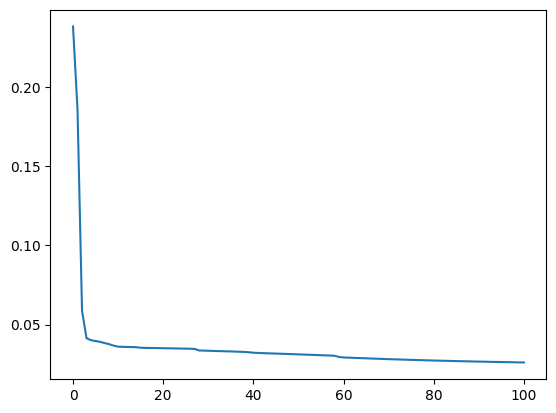

In [46]:
plt.plot(range(len(losslist)), losslist)

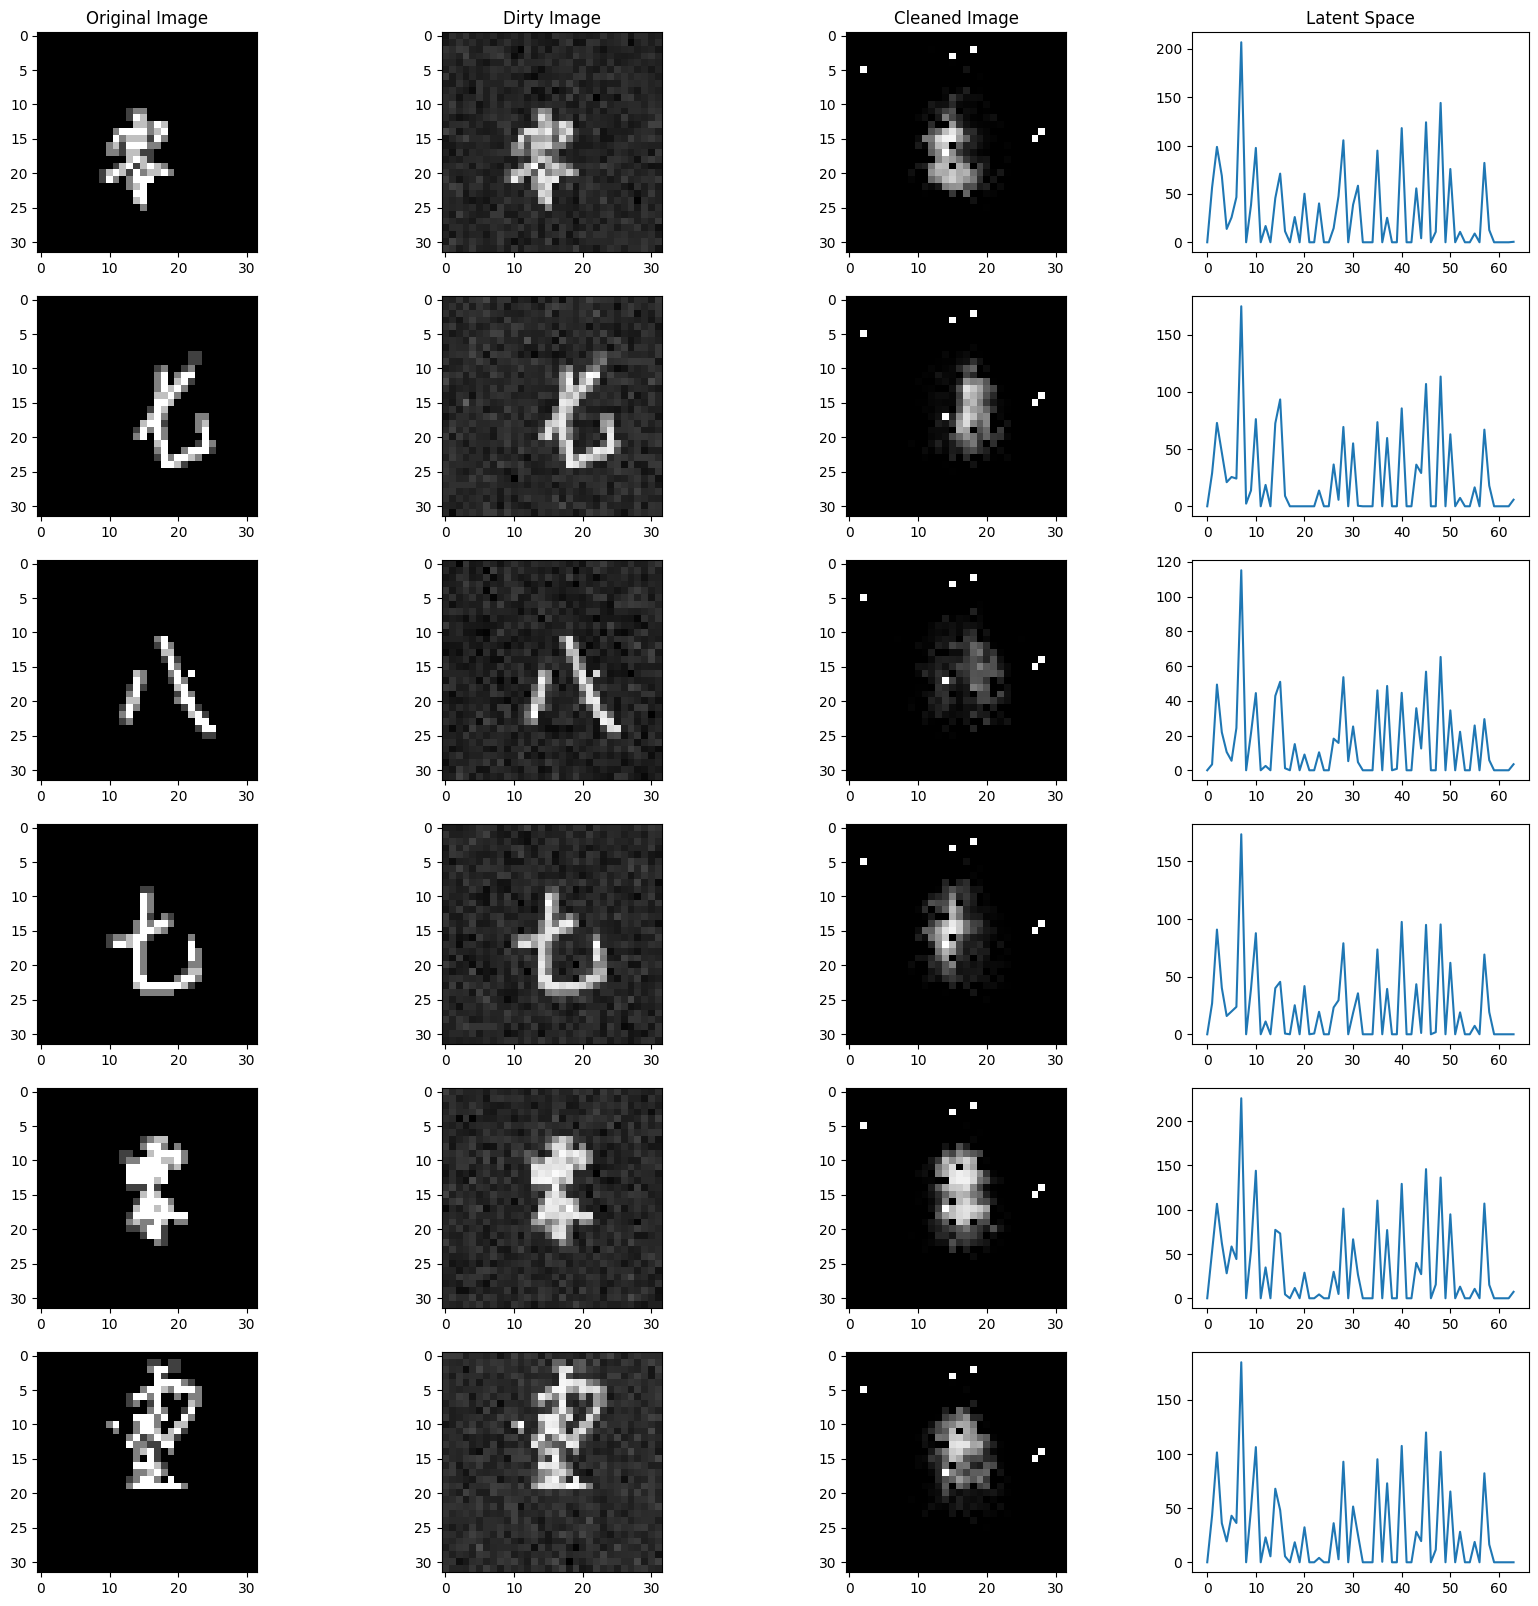

In [45]:
f, axes = plt.subplots(6, 4, figsize=(20, 20))
axes[0, 0].set_title("Original Image")
axes[0, 1].set_title("Dirty Image")
axes[0, 2].set_title("Cleaned Image")
axes[0, 3].set_title("Latent Space")

test_imgs = np.random.randint(0, 500, size=6)
for idx in range(6):
    dirty = testset[test_imgs[idx]][0]
    clean = testset[test_imgs[idx]][1]
    dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor)
    dirty = dirty.to(device)
    output = model(dirty)
    output_encoder = model.encoder(dirty)

    output = output.view(1, 32, 32)
    output = output.permute(1, 2, 0).squeeze(2)
    output = output.detach().cpu().numpy()

    dirty = dirty.view(1, 32, 32)
    dirty = dirty.permute(1, 2, 0).squeeze(2)
    dirty = dirty.detach().cpu().numpy()

    clean = clean.permute(1, 2, 0).squeeze(2)
    clean = clean.detach().cpu().numpy()

    latent = output_encoder.detach().cpu().numpy()
    latent = latent.reshape(-1,)

    axes[idx, 0].imshow(clean, cmap="gray")
    axes[idx, 1].imshow(dirty, cmap="gray")
    axes[idx, 2].imshow(output, cmap="gray")
    axes[idx, 3].plot(latent)

plt.show()